使用keras来对温度进行预测，数据在[这里](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip),

In [3]:
import os
data_dir = 'data'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')
f = open(fname)
# data = f.readlines()
data = f.read()
data = data.split('\n')
f.close()
header = data[0].split(',')
lines = data[1:]
print(header,len(header))
print(f'数据的长度为{len(lines)}')

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"'] 15
数据的长度为420551


In [4]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values
float_data.shape

(420551, 14)

In [5]:
from matplotlib import  pyplot as plt
temp = float_data[:,1] # label 
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

由于数据是每10分钟记录一个数据，那么一天将有144个数据。下面将前10天的数据绘制出来

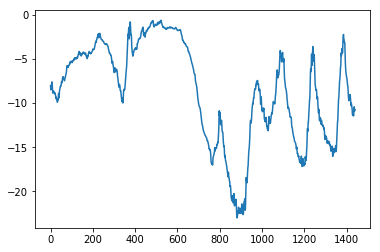

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

从上面图中可以看出每天的数据具有周期性，尤其是最后的4天有着明显的周期性。如果想根据过去几个月的数据来预测下一个月的平均温度，那么问题很简单，因为数据具有周期性。但是从上面的图中数据来看，似乎有些混乱，

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data/=std

### 时间序列准备训练数据的方法🌿

In [8]:
def generator(data,lookback, delay, min_index, max_index, shuffle=False, batch_size = 128, step = 6):
    """
    data:原始数据
    lookback:过去n步的数据
    delay:未来n步之后
    min_index和max_index:取出哪些数据
    shuffle:打乱样本
    batch_size:
    step:6为每小时抽取一个数据点
    """
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index, max_index, size = batch_size)# 一个批次的内容
        else:
            if i+batch_size >= max_index:
                i = min_index + lookback
            rows = np.range(i, min(i+batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step,data.shape[-1]))# (batch_size, 时间，features)
        targets = np.zeros((len(rows)))
        for j ,row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] # 【1】为target
        yield samples, targets

In [9]:
lookback = 1440
step = 6 # 为一个小时
delay = 144
batch_size = 128
train_gen = generator(float_data, 
                      lookback,
                      delay,
                      min_index=0, 
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data, 
                      lookback,
                      delay,
                      min_index=200000, 
                      max_index=300000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
train_gen = generator(float_data, 
                      lookback,
                      delay,
                      min_index=300000, 
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size


### 使用领域知识(a robust baseline )
在使用复杂的模型之前，我们先使用一些常识做一个baseline，往往这种基准方法很有用，例如一个不平衡的分类任务，假设有90%的A类，10%的为B类，那么分类任务一个基于常识的方法就是对新来的样本都预测为A类别，这样就有来90%的accuracy。所以任何分类起只有accuracy大于90%才能证明有效。在本数据集中我们可是使用这一种常识：`始终预测24小时后的温度等于现在的温度`。使用平均绝对误差(MAE)指标来评估这种方法。
$mae=np.mean(np.abs(preds-targets))$

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples,targets = next(val_gen)
        preds = samples[:,-1,1]# （batch中所有的样本，最后一个时刻，第一列）
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

val = evaluate_naive_method()

val * std[1]

0.2901310064666972


2.5683844684655397

### 全连接网络
下面先使用一个简单的模型，先将数据展平，通过两个全连接等(dense)，来做回归任务。评估的数据和评估的指标都和领域常识方法完全相同，

In [23]:
from keras.models import Sequential
from keras import  layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1]))) # 240 * 14
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) # no activation fun
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20, 
                              validation_data = val_gen, # 数据生成器
                              validation_steps = val_steps) # 步数
model.summary()


Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 2.8155 - val_loss: 1.3246
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 1.5386 - val_loss: 0.6979
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.8677 - val_loss: 0.5671
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.5238 - val_loss: 0.3203
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3755 - val_loss: 0.3313
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3586 - val_loss: 0.3082
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3466 - val_loss: 0.3058
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3511 - val_loss: 0.3156
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3488 - val_loss: 0.3669
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.339

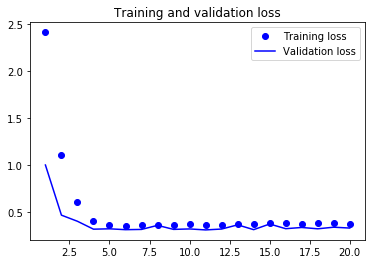

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### RNN baseline
training输入的数据（batch_size,time,features）,target (n,)

Epoch 1/3
500/500 [==============================] - 295s 589ms/step - loss: 0.2900 - val_loss: 0.2769
Epoch 2/3
500/500 [==============================] - 295s 590ms/step - loss: 0.2693 - val_loss: 0.2750
Epoch 3/3
500/500 [==============================] - 293s 586ms/step - loss: 0.2609 - val_loss: 0.2753


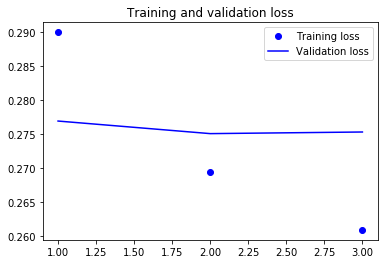

In [20]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=3, # 20 to seep up training 
                              validation_data = val_gen, # 数据生成器
                              validation_steps = val_steps) # 步数
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
